[View in Colaboratory](https://colab.research.google.com/github/iegorval/neural_nets/blob/master/Weather.ipynb)

#Getting Ready

In [0]:
# Installs
!pip install -U -q PyDrive

In [0]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras.layers import LSTM, Input, Activation, Dense, TimeDistributed
from keras.models import Sequential
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from io import StringIO
import keras.utils as utils
from keras import optimizers

In [0]:
# PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# Get all files from the root folder
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()

In [0]:
temperature_file = [(file['title'], file['id']) for file in file_list if file['title'].find('daily-minimum-temperatures')>=0]

In [67]:
f = drive.CreateFile({'id': temperature_file[0][1]})
content = f.GetContentString()
dataIO = StringIO(content)
df = pd.read_csv(dataIO, error_bad_lines=False)

b'Skipping line 3653: expected 2 fields, saw 3\n'


In [35]:
df.describe()

,Date,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
count,3650,3650
unique,3650,230
top,1987-10-28,10.0
freq,1,51


In [0]:
x_no_qm = [value[1].replace('?','') for value in df.values]
x_train_float = np.array([float(x) for x in x_no_qm])
x_train_norm = utils.normalize(x_train_float, axis=0, order=2)
x_train_reshaped = np.reshape(x_train_norm, (x_train_norm.shape[1],1))

In [0]:
context_length = 3
y_train = x_train_reshaped[context_length:,:]
train_np_expanded = np.repeat(x_train_reshaped[:,np.newaxis], context_length, 1)
for i in range(1,context_length):
    train_np_expanded[:-i,i,:] = train_np_expanded[i:,i,:]
x_train = train_np_expanded[:-context_length,:,:]

# Model

In [0]:
def get_model(c):
    model = Sequential()
    model.add(LSTM(64, input_shape=(c,1), return_sequences=False))
    model.add(Dense(1))
    model.add(Activation("linear"))
    return model

# Experiment

In [88]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [0]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model = get_model(context_length)
#model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
model.compile(loss='mean_squared_error', optimizer=sgd)

In [0]:
history = model.fit(x_train, y_train, epochs=50)

Epoch 1/50
3647/3647 [==============================] - 1s 337us/step - loss: 4.7413e-05
Epoch 2/50
3647/3647 [==============================] - 1s 322us/step - loss: 2.4719e-05
Epoch 3/50
3647/3647 [==============================] - 1s 284us/step - loss: 2.4718e-05
Epoch 4/50
3647/3647 [==============================] - 1s 285us/step - loss: 2.4711e-05
Epoch 5/50
3647/3647 [==============================] - 1s 261us/step - loss: 2.4720e-05
Epoch 6/50
3647/3647 [==============================] - 1s 262us/step - loss: 2.4710e-05
Epoch 7/50
3647/3647 [==============================] - 1s 273us/step - loss: 2.4727e-05
Epoch 8/50
3647/3647 [==============================] - 1s 281us/step - loss: 2.4698e-05
Epoch 9/50
3647/3647 [==============================] - 1s 292us/step - loss: 2.4723e-05
Epoch 10/50
3647/3647 [==============================] - 1s 279us/step - loss: 2.4719e-05
Epoch 11/50
  32/3647 [..............................] - ETA: 2s - loss: 1.8246e-05

3647/3647 [==============================] - 1s 267us/step - loss: 2.4698e-05
Epoch 12/50
3647/3647 [==============================] - 1s 296us/step - loss: 2.4715e-05
Epoch 13/50
3647/3647 [==============================] - 1s 291us/step - loss: 2.4707e-05
Epoch 14/50
3647/3647 [==============================] - 1s 286us/step - loss: 2.4699e-05
Epoch 15/50
3647/3647 [==============================] - 1s 285us/step - loss: 2.4705e-05
Epoch 16/50
3647/3647 [==============================] - 1s 263us/step - loss: 2.4700e-05
Epoch 17/50
3647/3647 [==============================] - 1s 256us/step - loss: 2.4722e-05
Epoch 18/50
3647/3647 [==============================] - 1s 258us/step - loss: 2.4700e-05
Epoch 19/50
3647/3647 [==============================] - 1s 260us/step - loss: 2.4699e-05
Epoch 20/50
3647/3647 [==============================] - 1s 290us/step - loss: 2.4709e-05
Epoch 21/50
 832/3647 [=====>........................] - ETA: 0s - loss: 2.6166e-05

3647/3647 [==============================] - 1s 267us/step - loss: 2.4691e-05
Epoch 22/50
3647/3647 [==============================] - 1s 246us/step - loss: 2.4698e-05
Epoch 23/50
3647/3647 [==============================] - 1s 280us/step - loss: 2.4691e-05
Epoch 24/50
3647/3647 [==============================] - 1s 302us/step - loss: 2.4692e-05
Epoch 25/50
  32/3647 [..............................] - ETA: 0s - loss: 1.9815e-05

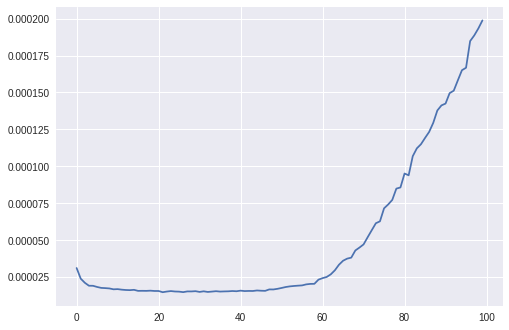

In [90]:
plt.plot(history.history['loss'])